# Fifth order methods & Lotka-Volterra problem

The extensisq methods of order 5 are compared to the explicit runge kutta methods of scipy on the Lotka-Volterra problem (predator prey model). This problem was copied from the solve_ivp page in scipy's reference manual.

## Problem definition
The parameters of this problem are defined as additional arguments (`args`) to the derivative function.

In [1]:
def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

problem = {'fun' : lotkavolterra,
            'y0' : [10., 5.],
        't_span' : [0., 15.],
          'args' : (1.5, 1, 3, 1)}

## Reference solution

First a reference solution is created by solving this problem with low tolerance.

In [2]:
from scipy.integrate import solve_ivp

reference = solve_ivp(**problem, atol=1e-12, rtol=1e-12, method='DOP853', dense_output=True)

## Solution plot

This solution and its derivatives change rapidly.

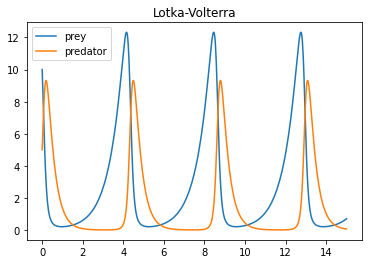

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(reference.t, reference.y.T)
plt.title('Lotka-Volterra')
plt.legend(('prey', 'predator'))
plt.show()

## Efficiency plot

The method is efficient if it can solve problems to low error with low cost. I will use the number of function evaluations as measure of cost. For the error measure I wil use the RMS of the error norm over all solution points. A function to calculate it is:

In [4]:
def rms_err_norm(solution, reference):
    error = solution.y - reference.sol(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Now let's solve this problem with the explicit runge kutta methods of scipy (`RK45` and `DOP853`) and those of extensisq (`Ts45`, `BS45`, `BS45_i`, `CK45` and `CK45_o`) at a few absolute tolerance values and make a plot to compare their efficiency. The bottom left corner of that plot is the efficiency sweet spot: low error and few fuction evaluations.

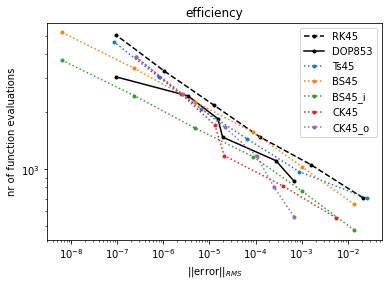

In [5]:
import numpy as np
from extensisq import *

methods = ['RK45', 'DOP853', Ts45, BS45, BS45_i, CK45, CK45_o]
tolerances = np.logspace(-4, -9, 6)

plt.figure()
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method,
                       dense_output=True) # only to separate BS45 and BS45_i
        err = rms_err_norm(sol, reference)
        e.append(err)
        n.append(sol.nfev)
    if name == 'RK45':
        style = '--k.'
    elif name == 'DOP853':
        style = '-k.'
    else:
        style = '.:'
    plt.loglog(e, n, style, label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('nr of function evaluations')
plt.title('efficiency')
plt.show()     

## Discussion

The efficiency graph shows:
* `RK45` has the poorest efficiency of all considered methods.
* `Ts45` is quite similar to `RK45`, but just a bit better.
* `BS45` and `BS45_i` are the most efficient fifth order methods for lower (tighter) tolerances. These two methods have exactly the same accuracy, but `BS45` needs more evaluations for its accurate interpolant. That interpolant is not used in this case. It was only enabeled, by setting `dense_output=True`, to show the difference with respect to `BS45_i`.
* `CK45` and `CK45_o` are the most efficient methods at higher (looser) tolerances. The performance at lower tolerance is similar to `Ts45`.
* `DOP853` is a higher order method (eighth). Typically, it is more efficient at lower tolerance, but for this problem and these tolerances it does not work so well.

These observation may not be valid for other problems.